In [25]:
## Initial Setup

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

import pandas as pd
import numpy

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt


bs = 64

path = Path('./FAST_Ultrasound_usingFASTAI_attempt3_JohnCullOnly')

np.random.seed(21) #locks the random seed



In [26]:

def floatlabeler(oof):
    func= lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[2]
    funcname= lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[3]
    frame = func(oof)
    framename = funcname(oof)
    print (frame)
    print (framename)
    
    if 'Quality1' in frame:
        label = 1.0
    if 'Quality2' in frame:
        label = 2.0
    if 'Quality3' in frame:
        label = 3.0
    if 'Quality4' in frame:
        label = 4.0
    if 'Quality5' in frame:
        label = 5.0
    return label
    

In [27]:
tfms = get_transforms(max_zoom=0, max_warp = None)
data = ImageList.from_folder(path).split_by_folder("train", "valid").label_from_func(floatlabeler, label_cls = FloatList).transform(tfms, size=224).databunch(no_check = True).normalize()

Quality1
video33327.mp4__frame176.png
Quality1
video33352.mp4__frame110.png
Quality1
video33352.mp4__frame22.png
Quality1
video33352.mp4__frame44.png
Quality1
video33352.mp4__frame66.png
Quality1
video33408.mp4__frame132.png
Quality1
video33409.mp4__frame66.png
Quality1
video33410.mp4__frame110.png
Quality1
video33410.mp4__frame132.png
Quality1
video33410.mp4__frame154.png
Quality1
video33410.mp4__frame176.png
Quality1
video33410.mp4__frame44.png
Quality1
video33410.mp4__frame66.png
Quality1
video33411.mp4__frame176.png
Quality1
video33412.mp4__frame110.png
Quality1
video33412.mp4__frame176.png
Quality1
video33412.mp4__frame22.png
Quality1
video33412.mp4__frame44.png
Quality1
video33616.mp4__frame110.png
Quality1
video33616.mp4__frame176.png
Quality1
video33616.mp4__frame22.png
Quality1
video33616.mp4__frame44.png
Quality1
video33643.mp4__frame110.png
Quality1
video33643.mp4__frame22.png
Quality1
video33643.mp4__frame44.png
Quality1
video33643.mp4__frame66.png
Quality1
video33643.mp4__

In [28]:
#data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(max_zoom=0, max_warp = None), size=224, bs=bs).normalize(imagenet_stats).split_by_folder('train', 'valid').label_from_func(floatlabeler, label_cls = FloatList)

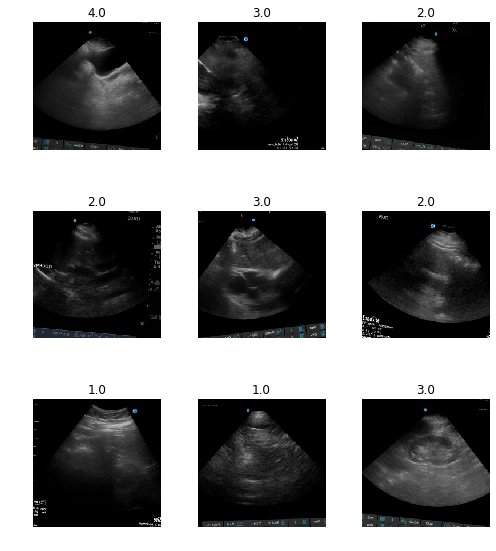

In [29]:
data.show_batch(rows=3, figsize = (7,8))

In [30]:
learn = cnn_learner(data, models.resnet34, metrics = mean_absolute_error, wd = 15)

In [31]:
#torch.nn.modules.Sigmoid??

In [32]:
def sigmoid_1to5(input, buffer=0):
    return (4+2*buffer) + torch.sigmoid(input) + (1-buffer)

class Sigmoid_1to5(torch.nn.Module):    
    def sigmoid_1to5(self, input, buffer=0):
        return (4+2*buffer) * torch.sigmoid(input) + (1-buffer)
    
    def forward(self, input):
        return self.sigmoid_1to5(input, buffer=2)

In [33]:
sig = Sigmoid_1to5()


In [34]:
x=torch.tensor(np.linspace(-10, 10, 50).astype(float))
y=sig(x)

In [35]:
learn.model[1].add_module(module = Sigmoid_1to5(), name = '9')

In [36]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

epoch,train_loss,valid_loss,mean_absolute_error,time
0,4.120160,1.988129,1.126988,00:06
1,3.653699,2.015445,1.134035,00:06
2,3.144360,0.987420,0.805236,00:06
3,2.656452,1.020625,0.814733,00:06
4,2.180036,1.053769,0.849328,00:06
5,1.840114,1.093625,0.877240,00:06
6,1.605244,1.118644,0.884054,00:06
7,1.415872,1.094357,0.868491,00:06
8,1.269450,1.060234,0.851314,00:06
9,1.165165,1.005083,0.827950,00:06


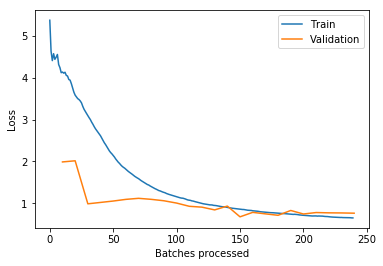

In [37]:
learn.fit_one_cycle(24)
learn.recorder.plot_losses()

In [39]:
learn.save('Test-1_JohnCull')

In [40]:
learn.unfreeze()

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


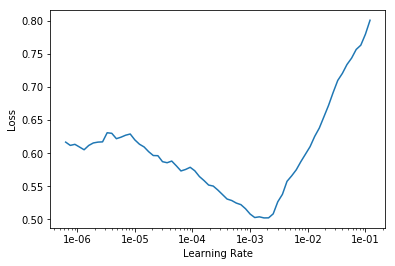

In [42]:
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.610876,0.741137,0.705389,00:07
1,0.591257,0.690363,0.681415,00:07
2,0.562764,0.640137,0.650390,00:07
3,0.524204,0.605305,0.614370,00:07
4,0.482042,0.603106,0.611996,00:07
5,0.439241,0.619776,0.615316,00:07
6,0.402634,0.607156,0.605481,00:07
7,0.373598,0.611068,0.608777,00:07
8,0.350127,0.623234,0.615725,00:07
9,0.329589,0.621161,0.615662,00:07


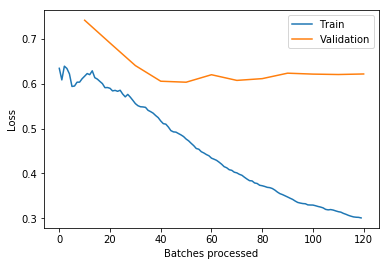

In [43]:
learn.fit_one_cycle(12, max_lr=slice(1e-05,1e-04))
learn.recorder.plot_losses()

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [45]:
#This grabs all the predictions for the validation set.
#The outputs is a 2 element Tensor with the first element being the predictions and the second element being the ground truths
preds = learn.get_preds(ds_type=DatasetType.Valid)

In [46]:
Valid_DF = pd.DataFrame([], columns = ['Predicted', 'Actual']).reset_index()
Valid_DF.head()

,index,Predicted,Actual


In [47]:
i = 0
for x,y in zip(preds[0], preds[1]):
    dfnew = pd.DataFrame({'Predicted': float(x), 'Actual': float(y)}, index = [i])
    Valid_DF = Valid_DF.append(dfnew, ignore_index=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [48]:
Valid_DF.head()
Valid_DF.to_csv('results.csv')

[2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 1, 2, 2, 2, 2, 2, 3, 4, 4, 3, 4, 4, 3, 2, 4, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 4, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 4, 2, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 2, 3, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 2, 3, 4, 2, 2, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 2, 2, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 2, 4, 4, 3, 4, 4, 4, 4, 4]
Confusion matrix, without normalization
[[13 24  0  0  0]
 [ 1 56 13  6  0]
 [ 0  9 42 12  0]
 [ 0  5 28 17  0]
 [ 0  1  3 14  0]]


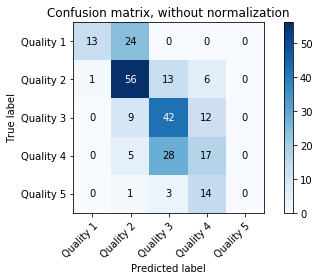

In [49]:
# confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  

CalQual = Valid_DF["Predicted"].values.tolist()
i = 0
for x in CalQual:
  if x<1:
    CalQual[i] = 1
  elif x> 5:
    CalQual[i] = 5
  else:
    CalQual[i] = round(x)
  i = i + 1
  
print(CalQual) 
  
TruQual = Valid_DF['Actual'].values.tolist()

a = plot_confusion_matrix(TruQual, CalQual, classes = ['Quality 1', 'Quality 2', 'Quality 3', 'Quality 4', 'Quality 5']) 
  
#plt.savefig("confusion_matrix_WOnorm.png")